<a href="https://colab.research.google.com/github/MoMus2000/Music-Gen/blob/master/MusicTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mido
import mido
import tensorflow

from mido import MidiFile, MidiTrack, Message
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout, Flatten
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np

     |████████████████████████████████| 61kB 5.0MB/s 


In [2]:
from music21 import converter, instrument, note, chord
notes = []
velocities = []

In [3]:
from glob import glob

In [6]:
for file in glob("/content/*.mid"):
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

In [7]:
from tensorflow.keras.utils import to_categorical

In [8]:
sequence_length = 100
# get all pitch names
pitchnames = sorted(set(item for item in notes))
# create a dictionary to map pitches to integers
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []
# create input sequences and the corresponding outputs
for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)
# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / np.max(network_input)
network_output = to_categorical(network_output)

In [9]:
print(network_output.shape)

(14158, 133)


In [10]:
import tensorflow as tf
def create_model(): 
  model = Sequential()
  model.add(tensorflow.keras.layers.Conv1D(256,3,input_shape=(network_input.shape[1], network_input.shape[2]),padding='same'))
  model.add(tf.keras.layers.MaxPooling1D(2,padding='same'))
  model.add(Dropout(0.5))
  model.add(tensorflow.keras.layers.Conv1D(256,3,padding='same'))
  model.add(tf.keras.layers.MaxPooling1D(2,padding='same'))
  model.add(Dropout(0.5))
  model.add(tensorflow.keras.layers.Conv1D(256,3,padding='same'))
  model.add(tf.keras.layers.MaxPooling1D(2,padding='same'))
  model.add(Dropout(0.5))
  model.add(tensorflow.keras.layers.Conv1D(256,3,padding='same'))
  model.add(tf.keras.layers.MaxPooling1D(2,padding='same'))
  model.add(tensorflow.keras.layers.Conv1D(256,3,padding='same'))
  model.add(tf.keras.layers.MaxPooling1D(2,padding='same'))
  model.add(Dropout(0.5))
  model.add(LSTM(512, return_sequences=True))
  model.add(LSTM(512, return_sequences=True))
  model.add(LSTM(512, return_sequences=True))
  model.add(LSTM(512, return_sequences=True))
  model.add(LSTM(256))
  model.add(Dropout(0.5))
  model.add(Dense(512,activation='relu'))
  model.add(Dense(256,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(128,activation='relu'))
  model.add(Dense(network_output.shape[1]))
  model.add(Activation('softmax'))
  return model
# lr_schedule = tensorflow.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-6 * 10**(epoch / 20))

# with tpu_strategy.scope():
model =  create_model()
model.compile(loss='categorical_crossentropy', optimizer=tensorflow.keras.optimizers.Adam(learning_rate= 0.00008))


In [12]:
history = model.fit(network_input, network_output, epochs=500, batch_size=256)

Epoch 1/500
56/56 [==============================] - 2s 42ms/step - loss: 0.4113
Epoch 2/500
56/56 [==============================] - 2s 42ms/step - loss: 0.4003
Epoch 3/500
56/56 [==============================] - 2s 42ms/step - loss: 0.4268
Epoch 4/500
56/56 [==============================] - 2s 42ms/step - loss: 0.3931
Epoch 5/500
56/56 [==============================] - 2s 42ms/step - loss: 0.3957
Epoch 6/500
56/56 [==============================] - 2s 42ms/step - loss: 0.3923
Epoch 7/500
56/56 [==============================] - 2s 42ms/step - loss: 0.3911
Epoch 8/500
56/56 [==============================] - 2s 42ms/step - loss: 0.3958
Epoch 9/500
56/56 [==============================] - 2s 42ms/step - loss: 0.3931
Epoch 10/500
56/56 [==============================] - 2s 43ms/step - loss: 0.3747
Epoch 11/500
56/56 [==============================] - 2s 43ms/step - loss: 0.3853
Epoch 12/500
56/56 [==============================] - 2s 43ms/step - loss: 0.3652
Epoch 13/500
56/56 [=====

In [13]:
import matplotlib.pyplot as plt

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1, 1, 5])

KeyError: ignored

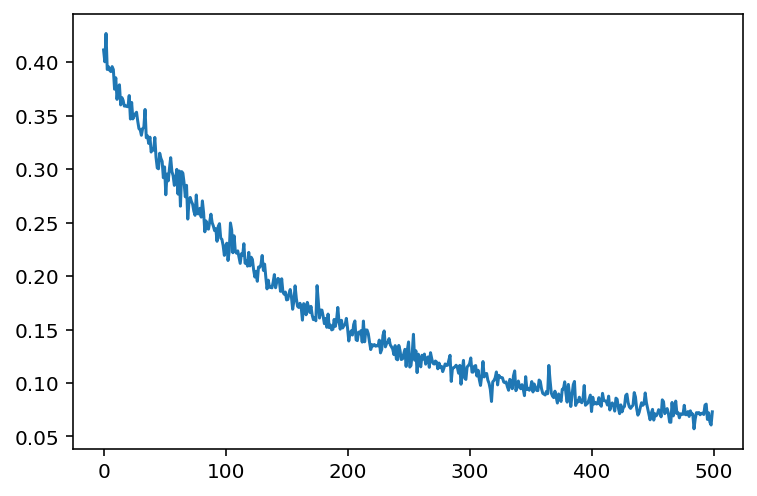

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])

In [20]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start].tolist()
prediction_output = []
# generate 500 notes
for note_index in range(200):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input 
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    print(result)
    prediction_output.append(result)
    pattern.append([index/48])
    pattern = pattern[1:len(pattern)]

2.5
F4
A4
B-3
A3
B-3
F5
E-5
0.3
F5
5.8
7.10
B-4
B-4
B-4
G3
3.7
B-3
8.0
G3
2.5
F5
2.5
F5
G3
F3
F5
F5
F5
F5
E-5
F5
F5
F5
3.7
F5
3.7
E-3
3.7
3.7
3.7
3.7
E-3
3.7
8.0
E-5
G#3
F5
E-5
F5
F5
F5
E-5
F5
E-5
E-5
E-5
D5
E-5
E-5
E-5
E-5
E-3
D5
G#3
F5
D5
E-5
E-5
F5
11.2
F5
D5
11.2
F5
7.10
3.7
E-5
3.7
E-5
0.3
0.3
0.3
0.3
3.7
3.7
5.8
G#3
G3
D5
D5
E-5
E-5
F5
G#5
E-5
E-5
E-5
E-5
E-5
3.7
E-5
3.7
3.7
3.7
3.7
3.7
E-5
3.7
E-5
7.10
3.7
B-3
7.10
E-5
3.7
10.3
F5
7.10
3.7
E-3
7.10
E-5
E-5
E-5
F5
F5
E-5
G#3
E-5
E-3
E-3
E-5
E-5
0.3
3.7
5.8
F5
F5
F#5
F#5
F#5
F#5
F#5
F5
7.10
F5
7.10
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
F5
F5
F5
F5
F5
B3
F5
G#3
G#3
E-5
D5
D5
D5
G#3
D5
C5
E-5
G#3
G#3
G#3
A3
A3
D5
11.2
F5
C#5
5.9
D5
7.10
3.7
3.7
7.10
7.10
3.7
3.7
3.7
3.7
3.7
C5
E-3
D5
B3
B3


In [21]:
offset = 0
output_notes = []
# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [22]:
from music21 import stream

In [23]:
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='/content/test_output.mid')

'/content/test_output.mid'

In [24]:
from google.colab import files
files.download('/content/test_output.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
model.save('/content/drive/My Drive/Music Gen')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Music Gen/assets
